# Milestone Project 2: SkimLit

The purpose of this notebook is to build a nlp model to make reading medical abstracts easier.

In [ ]:
# Confirm access to a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9306f09e-1a1d-1266-f916-231910cd8eff)


## Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!dir pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Cehck what files are in the PubMed_20k datset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir  = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Read filename and returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath
    """
    with open(filename, "r") as f:
        return f.readlines()


In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
len(train_lines)

210040

In [ ]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    """
    input_lines = get_lines(filename=filename)
    abstract_lines = ""
    abstract_samples = []
    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstact_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstact_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstact_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line 
    
    return abstract_samples

In [ ]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
# Check the first abstract
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distrbution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

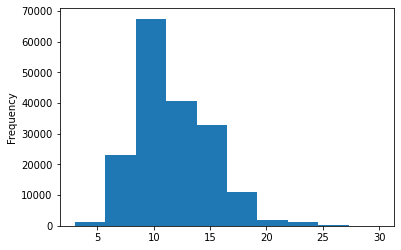

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Get text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))


train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels and ecode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting the baseline

In [ ]:
from multiprocessing import Pipe
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipelinw
model_0.fit(train_sentences, train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the baseline model
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

## Download our helper functions

In [ ]:
!wget --no-check-certificate https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-07 23:51:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-07 23:51:15 (70.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results

baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

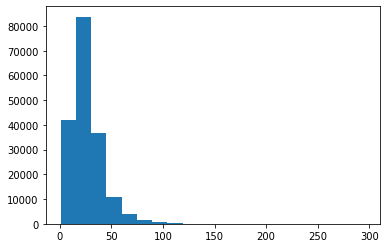

In [ ]:
# What's the distribution looks like
import matplotlib.pyplot as plt 
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of all sentences
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Max sequence lebgth
max(sent_lens)

296

## Create text vectorizer layer

In [ ]:
# How many words in out vocab
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                        output_sequence_length=55)

In [ ]:
# Fit text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Text out text vectorizer
import random
target_sentence = random.choice(train_sentences)
target_sentence, len(target_sentence.split()), text_vectorizer([target_sentence])

('the immune system has been implicated as one mechanism underlying the benefits of acupuncture therapy .',
 16,
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[   2,  988,  355,  139,  167, 4707,   25,   88, 1386, 1727,    2,
          593,    4,  373,   66,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>)

In [ ]:
# How many words in train vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab), rct_20k_text_vocab[:5], rct_20k_text_vocab[-5:]

(64841,
 ['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [ ]:
# Create token embedding later
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                output_dim=128,
                                mask_zero=True,
                                name="token_embedding")

In [ ]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape:\n {embedded_sentence.shape}\n")




Sentence before vectorization:
 the immune system has been implicated as one mechanism underlying the benefits of acupuncture therapy .

Sentence after vectorization:
 [[   2  988  355  139  167 4707   25   88 1386 1727    2  593    4  373
    66    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.02637245  0.02577693 -0.0246123  ...  0.01939184 -0.02208905
   -0.03792927]
  [ 0.03723978  0.02680207  0.00839517 ...  0.00177195  0.04906359
   -0.00655781]
  [-0.02687159  0.0440782   0.02616743 ... -0.03288586  0.00102152
    0.01608414]
  ...
  [ 0.00411354 -0.02438288  0.04031712 ... -0.03986143  0.0236956
    0.03414397]
  [ 0.00411354 -0.02438288  0.04031712 ... -0.03986143  0.0236956
    0.03414397]
  [ 0.00411354 -0.02438288  0.04031712 ... -0.03986143  0.0236956
    0.03414397]]]

Embedded senten

## Creating datasets

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
# Take the TensorSlice Dataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with token embeddings

In [ ]:
# Create a 1D model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset, 
                                steps_per_epoch = int(0.1*len(train_dataset)),
                                epochs=3,
                                validation_data = valid_dataset,
                                validation_steps =  int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 18s 10ms/step - loss: 0.9160 - accuracy: 0.6392 - val_loss: 0.6848 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6620 - accuracy: 0.7528 - val_loss: 0.6350 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6227 - accuracy: 0.7710 - val_loss: 0.6002 - val_accuracy: 0.7846


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6036 - accuracy: 0.7840


[0.6035815477371216, 0.7840262055397034]

In [ ]:
# Make predictions

model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.3257505e-01, 1.7388865e-01, 8.7764353e-02, 2.8258204e-01,
         2.3189841e-02],
        [4.3070951e-01, 3.0578917e-01, 1.3799269e-02, 2.4127740e-01,
         8.4246211e-03],
        [1.5073858e-01, 8.6410642e-03, 1.6063466e-03, 8.3898002e-01,
         3.4007164e-05],
        ...,
        [4.6979076e-06, 6.9712166e-04, 7.3817285e-04, 1.6691681e-06,
         9.9855834e-01],
        [5.1675938e-02, 4.5027703e-01, 1.0776451e-01, 6.6546112e-02,
         3.2373631e-01],
        [1.9538790e-01, 6.1687750e-01, 4.1102733e-02, 6.5187134e-02,
         8.1444725e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)


In [ ]:
# Calculate model_1 ressults
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.40262147491063,
 'precision': 0.7809878052409425,
 'recall': 0.7840262147491063,
 'f1': 0.7816746413860214}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embedding

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        dtype=tf.string,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Random sentence after embedding :\n {use_embedding_sentence[0][:30]}")
print(f"Length embedding :\n {len(use_embedding_sentence[0])}")




Random sentence:
 video laryngoscopy was performed using the glidescope cobalt avl video laryngoscope .
Random sentence after embedding :
 [-0.01601959  0.02712103  0.02918093 -0.06399287  0.00874708  0.04940464
  0.02046594  0.09124386 -0.0250986   0.01939738 -0.01301923  0.0153002
 -0.02941204  0.05694778  0.0570784   0.02931904  0.07912526  0.02118455
 -0.05620971 -0.07121544 -0.03186331 -0.01790318  0.00873002  0.00117425
 -0.09605182 -0.05386564  0.00377494  0.01096453 -0.0637212  -0.05901729]
Length embedding :
 512


## Building and fitting feature extaction using pretrined embeddings from Tensorflow hub

In [ ]:
# Define the input shape
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model 2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9149 - accuracy: 0.6518 - val_loss: 0.7960 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7700 - accuracy: 0.7016 - val_loss: 0.7559 - val_accuracy: 0.7078
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7552 - accuracy: 0.7101 - val_loss: 0.7421 - val_accuracy: 0.7131


In [ ]:
# Evaluate on the valid dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7438 - accuracy: 0.7122


[0.7437555193901062, 0.7122335433959961]

In [ ]:
# Make predictions

model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

(array([[0.43573603, 0.36693975, 0.00228205, 0.18791617, 0.00712608],
        [0.30777118, 0.53897804, 0.00331767, 0.14755383, 0.00237928],
        [0.2240685 , 0.12298054, 0.0185735 , 0.6006714 , 0.03370602],
        ...,
        [0.00196284, 0.00626943, 0.06529324, 0.00106419, 0.9254103 ],
        [0.00376071, 0.04309893, 0.18138091, 0.00175274, 0.7700067 ],
        [0.18304263, 0.27576855, 0.4810637 , 0.00801035, 0.05211476]],
       dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)

In [ ]:
# Calculate model_2 ressults
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.22335495829472,
 'precision': 0.7123104339051511,
 'recall': 0.7122335495829472,
 'f1': 0.7091050781074631}

## Model 3: Conv1D with character embeddings

### Create a character-level tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting
split_chars(random_train_sentence)

'v i d e o   l a r y n g o s c o p y   w a s   p e r f o r m e d   u s i n g   t h e   g l i d e s c o p e   c o b a l t   a v l   v i d e o   l a r y n g o s c o p e   .'

In [ ]:
# Split sequence level data into character-level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

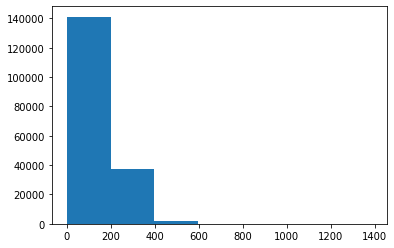

In [ ]:
# Cehck the distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [ ]:
# Find what character length covers 95%
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase+string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
# Adapt it to our training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(random_train_chars)
print(len(random_train_chars))
vectorized_chars = char_vectorizer([random_train_chars])
print(vectorized_chars)

t h e   a v e r a g e   d i a g n o s t i c   i m a g i n g   t o   t r e a t m e n t   t i m e   w a s   @   d a y s   f o r   t h e   t e l e o p h t h a l m o l o g i c   g r o u p   a n d   @   d a y s   f o r   t h e   r o u t i n e   g r o u p   ,   f o r   a   d i f f e r e n c e   o f   @   d a y s   (   @   %   c i   ,   @   t o   - @   d a y s   ;   p   =   @   )   .
379
tf.Tensor(
[[ 3 13  2  5 21  2  8  5 18  2 10  4  5 18  6  7  9  3  4 11  4 15  5 18
   4  6 18  3  7  3  8  2  5  3 15  2  6  3  3  4 15  2 20  5  9 10  5 19
   9 17  7  8  3 13  2  3  2 12  2  7 14 13  3 13  5 12 15  7 12  7 18  4
  11 18  8  7 16 14  5  6 10 10  5 19  9 17  7  8  3 13  2  8  7 16  3  4
   6  2 18  8  7 16 14 17  7  8  5 10  4 17 17  2  8  2  6 11  2  7 17 10
   5 19  9 11  4  3  7 10  5 19  9 14  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

## Creating character level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")


In [ ]:
# Test out character embedding layer
print(random_train_chars)
char_embed_example = (char_embed(char_vectorizer([random_train_chars])))
print(char_embed_example)

t h e   a v e r a g e   d i a g n o s t i c   i m a g i n g   t o   t r e a t m e n t   t i m e   w a s   @   d a y s   f o r   t h e   t e l e o p h t h a l m o l o g i c   g r o u p   a n d   @   d a y s   f o r   t h e   r o u t i n e   g r o u p   ,   f o r   a   d i f f e r e n c e   o f   @   d a y s   (   @   %   c i   ,   @   t o   - @   d a y s   ;   p   =   @   )   .
tf.Tensor(
[[[-0.00607189 -0.00682992  0.03644026 ... -0.00798982  0.04605107
   -0.02546601]
  [ 0.00266849 -0.04584024  0.00131065 ...  0.04580153  0.02390159
   -0.00332025]
  [ 0.01792369 -0.01625059 -0.01235769 ... -0.00798261  0.01389941
    0.03192485]
  ...
  [-0.04930536  0.01558468 -0.00464697 ... -0.035308   -0.04143305
    0.00213522]
  [-0.04930536  0.01558468 -0.00464697 ... -0.035308   -0.04143305
    0.00213522]
  [-0.04930536  0.01558468 -0.00464697 ... -0.035308   -0.04143305
    0.00213522]]], shape=(1, 290, 25), dtype=float32)


## Building a Conv1D model to fit character-level tokenization

In [ ]:
# Make Cov1D on char only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embeddings")

# Fit the model
model_3.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
# Turn our data into TensorFlow Datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Fit the model
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2511 - accuracy: 0.4926 - val_loss: 1.0287 - val_accuracy: 0.5904
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0000 - accuracy: 0.5968 - val_loss: 0.9346 - val_accuracy: 0.6326
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9250 - accuracy: 0.6384 - val_loss: 0.8667 - val_accuracy: 0.6656


In [ ]:
# Make predictions

model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs, model_3_pred_probs.shape

(array([[0.16876908, 0.40507022, 0.07694087, 0.2883091 , 0.06091072],
        [0.11515556, 0.1807993 , 0.01156108, 0.66489005, 0.02759393],
        [0.08800044, 0.13156714, 0.03701454, 0.72854584, 0.01487209],
        ...,
        [0.01226021, 0.03578271, 0.09181116, 0.0332895 , 0.82685643],
        [0.03430886, 0.17644896, 0.37068292, 0.06080519, 0.35775408],
        [0.49778593, 0.38028717, 0.03695955, 0.07337133, 0.01159604]],
       dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)

In [ ]:
# Calculate model_3 ressults
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.72884946378922,
 'precision': 0.6539347571589507,
 'recall': 0.6572884946378922,
 'f1': 0.6487144628011173}

## Model 4: Combining pretrained token embeddings

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype = tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3 Concatenate 1 and 2
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                          outputs=output_layer,
                          name="model_4_token_and_char_embeddings")





In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

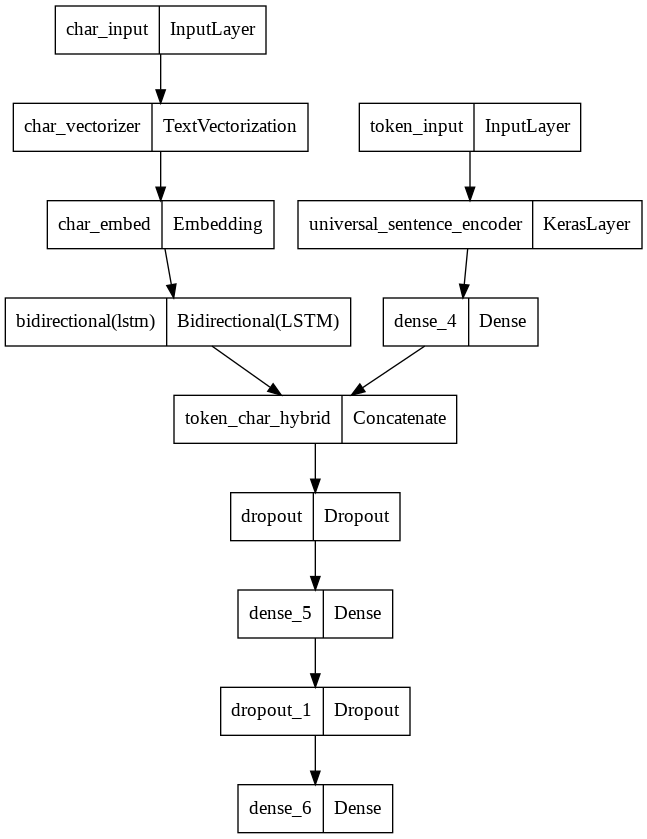

In [ ]:
# Plot the hybrid model
from keras.utils.vis_utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character datset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences


In [ ]:
#Fitting a model on token and character-level sequences
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 *len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 57ms/step - loss: 0.9846 - accuracy: 0.6079 - val_loss: 0.7802 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8050 - accuracy: 0.6922 - val_loss: 0.7184 - val_accuracy: 0.7291
Epoch 3/3
562/562 [==============================] - 24s 44ms/step - loss: 0.7787 - accuracy: 0.7008 - val_loss: 0.6939 - val_accuracy: 0.7390


In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs, model_4_pred_probs.shape

(array([[4.6839005e-01, 3.5241893e-01, 4.6083722e-03, 1.6883519e-01,
         5.7474496e-03],
        [3.3274722e-01, 5.0940955e-01, 3.4683496e-03, 1.5200779e-01,
         2.3670390e-03],
        [3.2576805e-01, 1.4954181e-01, 4.6491340e-02, 4.4075853e-01,
         3.7440307e-02],
        ...,
        [1.0734167e-03, 7.6767211e-03, 5.7925146e-02, 4.1532065e-04,
         9.3290937e-01],
        [1.5120633e-02, 8.2589000e-02, 2.2986604e-01, 6.2447842e-03,
         6.6617960e-01],
        [3.6322096e-01, 3.5300761e-01, 2.0456509e-01, 3.5216186e-02,
         4.3990131e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)

In [ ]:
# Calculate model_4 ressults
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.61313385409771,
 'precision': 0.7370986767859927,
 'recall': 0.7361313385409771,
 'f1': 0.7347116647053358}

## Model 5 : Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

### Create positional embeddings

In [ ]:
# How many different line numbers are ther
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

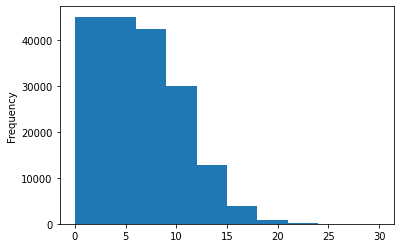

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use tensorflow to create one-hot encoded tensors
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
# How many different numbers of lines are there
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

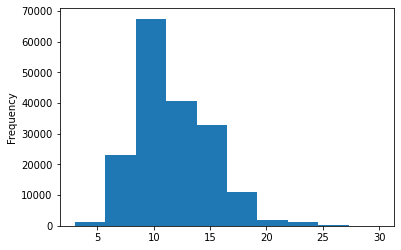

In [ ]:
# Check the distribution of "total_line" column
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use tensorflow to create one-hot encoded tensors
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building the tribride model


In [ ]:
from pyparsing import line
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype = tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line number inputs model
line_number_inputs = layers.Input(shape=(15,), dtype = tf.float32, name="line_number_input")
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype = tf.float32, name="total_lines_input")
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

# 5. Concatenate 1 and 2
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                  char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6 Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="chat_token_positional_embedding")([line_number_model.output,
                                                                                total_line_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put all together
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input], outputs = output_layer)

In [ ]:


model_5.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']     

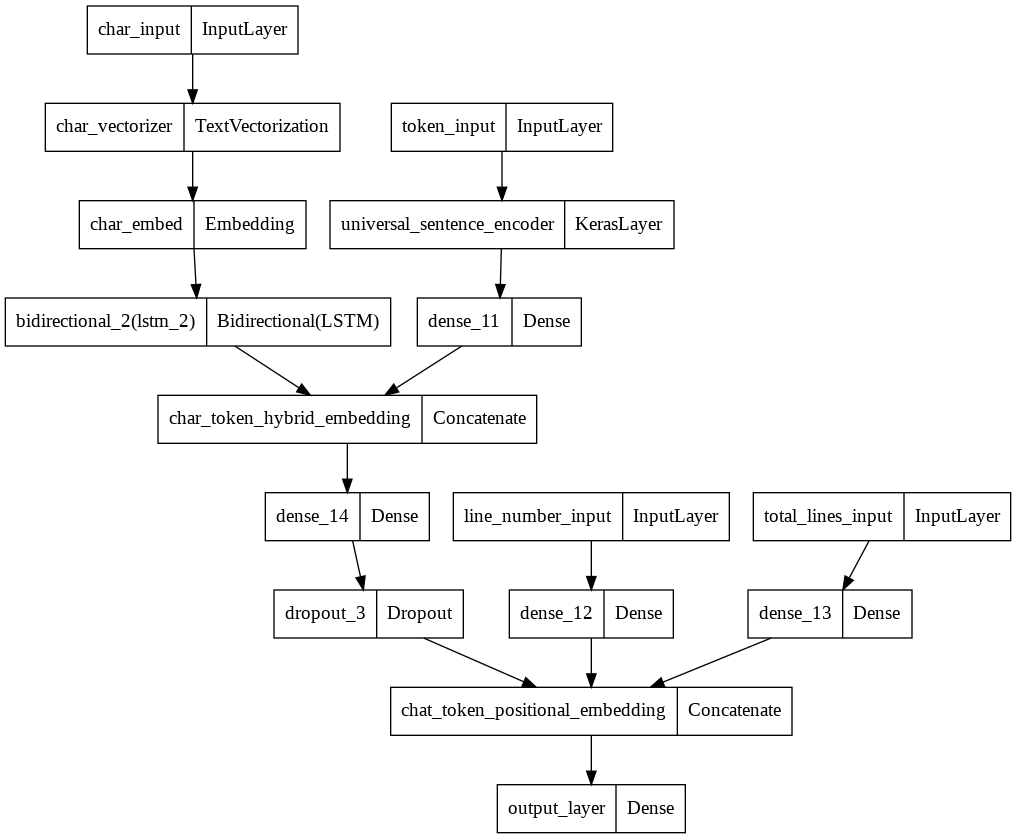

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_5)

In [ ]:
# Compiling the model
model_5.compile(loss=tf.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding dataset

In [ ]:
# Create training and validation datasetss with all four kinds of inputs
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Valid dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting the tribrid model

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 49ms/step - loss: 0.8983 - accuracy: 0.8664 - val_loss: 0.9252 - val_accuracy: 0.8364
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.9127 - accuracy: 0.8517 - val_loss: 0.9164 - val_accuracy: 0.8484
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9159 - accuracy: 0.8480 - val_loss: 0.9219 - val_accuracy: 0.8441


In [ ]:
# Make predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs, model_5_pred_probs.shape

In [ ]:
# Convert pred probs to classes
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)

In [ ]:
# Calculate model_4 ressults
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

In [ ]:
model_4_results

{'accuracy': 73.61313385409771,
 'precision': 0.7370986767859927,
 'recall': 0.7361313385409771,
 'f1': 0.7347116647053358}

## Compare model results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.402621,0.780988,0.784026,0.781675
model_2_pretrained_token_embedding,71.223355,0.712310,0.712234,0.709105
model_3_custom_char_embedding,65.728849,0.653935,0.657288,0.648714
model_4_hybrid_char_token_embedding,73.613134,0.737099,0.736131,0.734712
model_5_pos_char_token_embedding,83.284788,0.832338,0.832848,0.831998


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

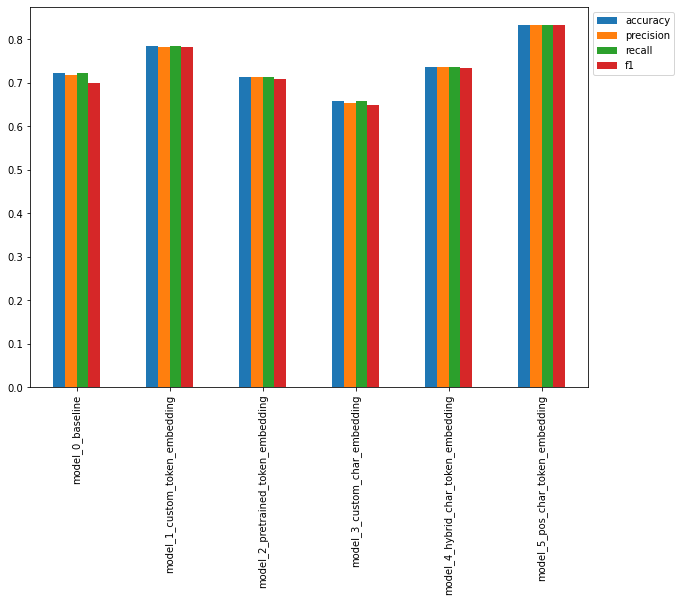

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

## Save and load model

In [ ]:
# Save the best performing model
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in the model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make prediction with our loaded model
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis = 1)
loaded_model_results = calculate_results(val_labels_encoded, loaded_preds)


In [ ]:
loaded_model_results

{'accuracy': 84.5690454124189,
 'precision': 0.8452715355313668,
 'recall': 0.8456904541241891,
 'f1': 0.8448644467765509}

In [ ]:
model_5_results

{'accuracy': 83.28478750165496,
 'precision': 0.832337730033586,
 'recall': 0.8328478750165497,
 'f1': 0.8319975651937662}